# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [ ]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/Colab Notebooks/drive-download-20241017T052515Z-001/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/drive-download-20241017T052515Z-001/test'
val_path = '/content/drive/MyDrive/Colab Notebooks/drive-download-20241017T052515Z-001/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 256 * 1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

# Load ResNet18 and modify it for grayscale and binary classification
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)


# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)

# Define criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# criterion = nn.CrossEntropyLoss()
# optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Loop

In [ ]:
# hyperparameter
# lr = 0.001
# weight_decay = 0.001

# epochs = 20
# optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
# lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
# criterion = nn.CrossEntropyLoss()

# save checkpoint
# save = 'model'

In [ ]:
lr = 0.001
weight_decay = 0.001
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 20
save = 'model'
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/20 - loss: 0.6906 - train_acc: 49.02% - val_loss: 0.6874 - val_acc: 50.00% - time: 71.29s
Epoch 2/20 - loss: 0.6160 - train_acc: 80.52% - val_loss: 0.7281 - val_acc: 56.25% - time: 71.14s
Epoch 3/20 - loss: 0.5659 - train_acc: 89.11% - val_loss: 0.7605 - val_acc: 56.25% - time: 69.71s
Epoch 4/20 - loss: 0.5568 - train_acc: 90.62% - val_loss: 0.6473 - val_acc: 75.00% - time: 69.43s
Epoch 5/20 - loss: 0.5528 - train_acc: 90.58% - val_loss: 0.6973 - val_acc: 50.00% - time: 71.00s
Epoch 6/20 - loss: 0.5457 - train_acc: 92.77% - val_loss: 0.6908 - val_acc: 62.50% - time: 68.94s
Epoch 7/20 - loss: 0.5426 - train_acc: 92.63% - val_loss: 0.8072 - val_acc: 50.00% - time: 70.53s
Epoch 8/20 - loss: 0.5413 - train_acc: 93.55% - val_loss: 0.6220 - val_acc: 75.00% - time: 69.12s
Epoch 9/20 - loss: 0.5369 - train_acc: 94.24% - val_loss: 0.7356 - val_acc: 56.25% - time: 70.64s
Epoch 10/20 - loss: 0.5340 - train_acc: 94.73% - val_loss: 0.6473 - val_acc: 81.25% - time: 69.14s
Epoch 11/20 - loss:

# Graph

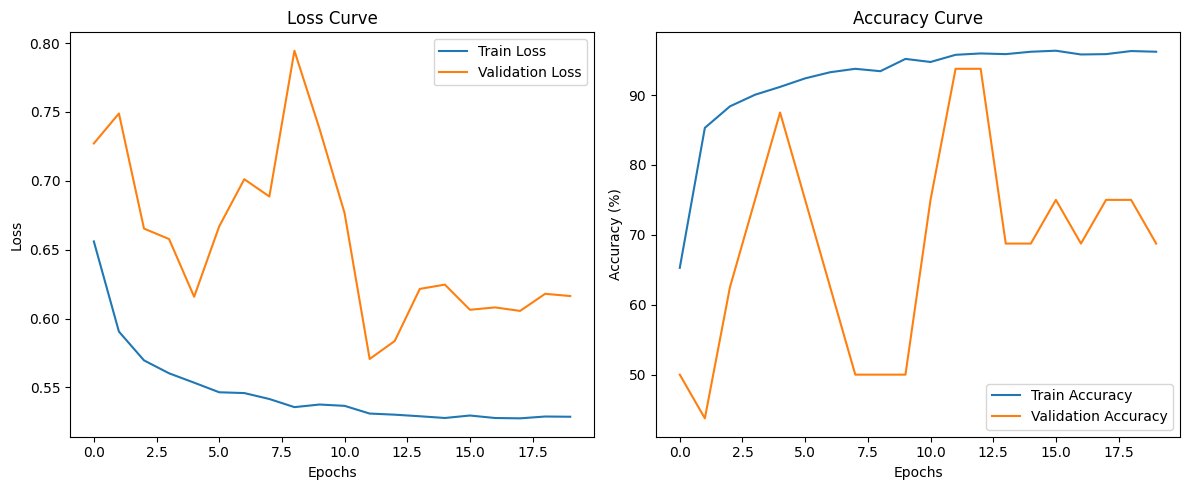

In [ ]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)

<ipython-input-11-54ee45e3a212>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model weights loaded successfully.
Test Accuracy: 83.49%
Test Loss: 0.4760
